## Classification
The aim of this section is to apply supervised learning methods to create a classification model to determine if tweets are an actual emergency. With this model, depending on success, could be used to predict a variety of other themes, given the appropriate class labelling. The class label have already been pre-labellel under the column _target_, and shows 1 if the tweet has been classified as an emergency, and 0 if not. The original [file can be found here](/tweets-raw.csv).

It is important to preface that this dataset faces the classic class imbalance problem, given that emergency tweets (1) constitutes only 18.5% of records before cleaning. Hence, there will need to be techniques applied to account for class imbalances. For instance, F1-score is more telling than Accuracy measures. We chose to oversample instead of undersample as it would mean disposing of 7k more records of non-emergencies(0), which would mean an even smaller training set after cleaning. 

Here is the order you will expect as you read the rest of this report:
1. [Data pre-processing](#1-data-preprocessing). The tweets are seen as is. For example, besides the actual text, emojis, vulgarities, hashtags are present with varying characters. Location range from actual values such as United States of America to "hell" or "jesus". 
2. [Feature engineering](#2-Feature-engineering). The keyword column, which contain the "emergency" word in the sentence, will be added to the feature list. The sentences will be tokenised and vectorised using a Term Frequency-Inverse Document Frequency (TF-IDF) approach.
3. [Dataset splitting](#3-dataset-splitting). We will need a training set, and a test set. We have decided to employ the holdout method, which uses 2/3 of the data for model training. 
4. [Model selection](#4-model-selection). We will attempt to use [decision tree induction](#attempted-run-using-decision-tree-classifier-with-significantly-more-execution-time-of-10s), linear regression, and Naïve (Complement) Baynesian Classification]. We may also further consider ensemble methods, random forest and boosting via AdaBoost. 
5. [Training phase](#5-training-phase). Models will be applied on keyword and the fragmented sentences as features. 
6. [Evaluation phase](#6-evaluation-phase). Here, we will apply metrics using the confusion matrix, the Receiver Operating Characteristics Curve and F1-score as previously mentioned. 


In [ ]:
! pip install Keras
! pip install tensorflow
! pip install scikit-learn


### 1. Data Preprocessing

In this phase, we remove punctuations and emojis. Though we are aware that this might affect sentence semantics, especially if we choose to adopt encoder-only transformers, it is relatively easy to roll back. For now, emojis and punctuation will not be considered.

We also realised it was important to remove stop words, numbers, and undergo lemmasation (removing of _-ings_). Source: Web Data Mining, Bing Liu

In [ ]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('tweetsv2.csv')

# Here, we can see that we have a imbalanced data set, with over 3 times the count of non-emergency tweets compared to emergency ones
df['target'].value_counts()

In [ ]:
import pandas as pd
import re
# from tensorflow.keras.preprocessing.text import text_to_word_sequence

# Read the CSV file
df = pd.read_csv('tweetsv2.csv')

# Emoji removal source taken from: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

df['cleantweet'] = df['text.1'].apply(lambda x: remove_emojis(remove_punctuation(str(x))))

print(df['cleantweet'][0])

display(df.head())

### 2. Feature Engineering

In [ ]:
X = df['cleantweet']
y = df['target']
len(X)
X.head()

### 3. Dataset splitting

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 33)
len(X_test)

### 4. Model selection

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report


### 5. Training phase

With the inclusion of stop words, performance improvements were seen. 

Original:

MNB: 0.846
CNB: 0.867
SVC: 0.894

After stop-words dropped:
MNB: 0.856
CNB: 0.863
SVC: 0.892

After n-gram range added:
MNB: 0.847
CNB: 0.889
SVC: 0.893

stop_words = 'english'


In [ ]:
# Create a pipeline for the different classification functions
pipeline_MNB = Pipeline([('tfidf', TfidfVectorizer(stop_words = 'english', ngram_range=(1,3))), ('clf', MultinomialNB())])
pipeline_CNB = Pipeline([('tfidf', TfidfVectorizer(stop_words = 'english', ngram_range=(1,3))), ('clf', ComplementNB())])
pipeline_SVC = Pipeline([('tfidf', TfidfVectorizer(stop_words = 'english', ngram_range=(1,3))), ('clf', LinearSVC())])

pipeline_MNB.fit(X_train, y_train)
predictMNB = pipeline_MNB.predict(X_test)
print(f"MNB: {accuracy_score(y_test, predictMNB):.3f}")

pipeline_CNB.fit(X_train, y_train)
predictCNB = pipeline_CNB.predict(X_test)
print(f"CNB: {accuracy_score(y_test, predictCNB):.3f}")

pipeline_SVC.fit(X_train, y_train)
predictSVC = pipeline_SVC.predict(X_test)
print(f"SVC: {accuracy_score(y_test, predictSVC):.3f}")

In [8]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.svm import LinearSVC
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from sklearn.model_selection import train_test_split

# # Assuming df['cleantweet'] and df['target'] are defined
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(df['cleantweet'])
# y = df['target']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# clf = make_pipeline(StandardScaler(with_mean=False),
#                     LinearSVC(random_state=0, tol=1e-5, max_iter=10000, class_weight='balanced'))
# clf.fit(X_train, y_train)

# predictSVC = clf.predict(X_test)

# cm = confusion_matrix(y_test, predictSVC)
# ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot()
# plt.show()


### Attempted run using Decision Tree classifier, with significantly longer execution time of >10s
Lower accuracy likely due to skewed data distribution. Oversampling recommended due to likelihood of a few leaves being labeled as 'emergency'.

Accuracy: 0.838

In [ ]:
from sklearn.tree import DecisionTreeClassifier

pipelineDT = Pipeline([('tfidf', TfidfVectorizer(stop_words = 'english', ngram_range=(1,3))), ('dtclf', DecisionTreeClassifier(random_state=1))])

pipelineDT.fit(X_train, y_train)

y_pred = pipelineDT.predict(X_test) 

accuracy = accuracy_score(y_test, y_pred) 
print(f'Accuracy: {accuracy:.3f}')



### Attempt using logistic regression
Execution time: 3.3s with accuracy of 0.850

In [ ]:
from sklearn.linear_model import LogisticRegression

pipelineLR = Pipeline([('tfidf', TfidfVectorizer(stop_words = 'english', ngram_range=(1,3))), ('dtclf', LogisticRegression(random_state=0))])

pipelineLR.fit(X_train, y_train)

y_pred = pipelineLR.predict(X_test) 

accuracy = accuracy_score(y_test, y_pred) 
print(f'Accuracy: {accuracy:.3f}')



### Attempt using
Execution time: s with accuracy of 

### 6. Evaluation phase
Given that our dataset is skewed, accuracy as a measure may be less accurate. 
- Precision is the number of **correctly classified positive** examples _divided_ by the total number of examples classified as positive. 
- Recall is the number of **correctly classified positive** examples _divided_ by the total number of actual positives in the test set. 

In [ ]:
print(classification_report(y_test, predictSVC))

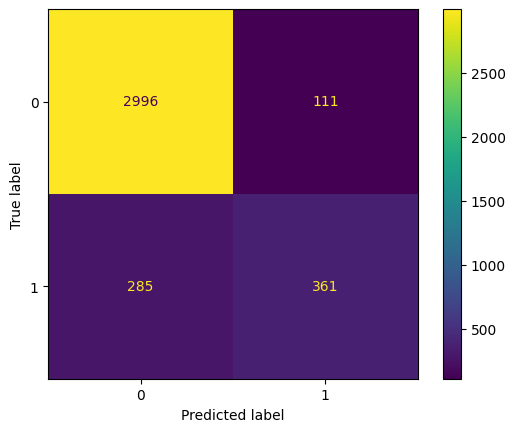

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming df['cleantweet'] and df['target'] are defined
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['cleantweet'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

clf = LinearSVC(random_state=0)

clf.fit(X_train, y_train)
predictSVC = clf.predict(X_test)

cm = confusion_matrix(y_test, predictSVC)
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot()
plt.show()

### Sample run using Support Vector Classifier

In [14]:
msg = "Severe weather expected in Lyon"
outcome = pipeline_SVC.predict([msg])
print('class label is ' + str(outcome))

msg2 = "Intense flying cow expected in Lyon"
outcome2 = pipeline_SVC.predict([msg2])
print('class label is ' + str(outcome2))

class label is [1]
class label is [0]
